# Goal 2: Predict whether a respondent has a mental health disorder (Random Forest / Deep Learning with Sentence-BERT)

In [1]:
#!pip install sentence_transformers
#!pip install tf-keras
#!pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [3]:
df = pd.read_csv("../data/processed/combined_clean_data.csv")

<br>

# Prepare the Dataset for Machine Learning models

Filter out rows where `Do you currently have a mental health disorder?` is not `Yes` or `No`.
Keep only `Yes` and `No`.


In [4]:
df = df[df["Do you currently have a mental health disorder?"].isin(["Yes","No"])].copy() 

### Create binary target

In [5]:
df["Do you currently have a mental health disorder?"] = (df["Do you currently have a mental health disorder?"] == "Yes").astype(int)

print(df["Do you currently have a mental health disorder?"].value_counts())
print(df.shape)

Do you currently have a mental health disorder?
1    1368
0    1134
Name: count, dtype: int64
(2502, 26)


## Remove redundant / data-leak columns

Some columns should be removed because they either contain identifiers or information that leaks the target label.
`SurveyID` is purely an ID field and does not provide any meaningful predictive value.


In [6]:
cols_to_drop = [
    "If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?",
    "SurveyID"
]

df.drop(columns=cols_to_drop, inplace=True)

## Splitting the data
- **`y`** is the target column: `"Do you currently have a mental health disorder?"`
- **`X`** contains all other columns (the features), created by dropping the target column.

In [7]:
y = df["Do you currently have a mental health disorder?"]
X = df.drop(columns=["Do you currently have a mental health disorder?"])

## One-Hot Encoding for machine learning
Convert categorical values to numeric one-hot vectors.

In [8]:
text_col = "all_text"

# Categorical columns (except the text column)
cat_cols = X.select_dtypes(include="object").drop(columns=[text_col]).columns

# Numeric columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Force dense output
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = ohe.fit_transform(X[cat_cols])
X_num = X[num_cols].to_numpy()

## Sentence-BERT Embeddings
We load a Sentence-BERT model and convert the `all_text` column into dense numerical embeddings. These embeddings capture semantic meaning and will be combined with the other features.

In [9]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

texts = X["all_text"].tolist()
embeddings = model.encode(texts, show_progress_bar=True)

X_final = np.hstack([X_cat, X_num, embeddings])

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [10]:
ohe_cols = ohe.get_feature_names_out(cat_cols)
num_cols_list = num_cols.tolist()
embedding_cols = [f"embed_{i}" for i in range(embeddings.shape[1])]

all_columns = list(ohe_cols) + num_cols_list + embedding_cols

df_final = pd.DataFrame(X_final, columns=all_columns)
df_final.head()

,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_No,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Partial,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Unknown,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?_Yes,Do you have a family history of mental illness?_No,Do you have a family history of mental illness?_Unknown,Do you have a family history of mental illness?_Yes,Do you know the options for mental health care available under your employer-provided health coverage?_No,Do you know the options for mental health care available under your employer-provided health coverage?_Unknown,Do you know the options for mental health care available under your employer-provided health coverage?_Yes,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.026818,-0.015413,0.021294,0.044119,-0.025731,0.019960,0.009756,0.003721,0.036581,0.032038
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.009811,-0.015497,0.006308,0.051385,-0.028361,0.017360,-0.004252,-0.014771,0.040657,0.016266
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.055769,-0.016270,-0.005475,0.000252,-0.023580,0.067008,-0.032347,-0.002063,0.065970,-0.007730
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.041897,-0.008682,-0.018392,0.060992,-0.037049,-0.093029,0.039607,0.016642,0.020170,0.017305
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.000546,-0.042394,-0.004494,0.071748,-0.052826,-0.014231,0.013555,-0.020264,0.053745,-0.025046


## Train/test split
We split the data so that **80%** is used for training the model and **20%** is kept aside for testing. This allows us to evaluate how well the model generalizes to unseen data.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size= 0.2, random_state=5)

## Model Evaluation

This section defines a reusable evaluation function that can be applied to any 
classifier that supports `predict()` and (optionally) `predict_proba()` for ROC-AUC.  
If the model exposes `feature_importances_`, the function also reports and plots 
the top-N most important features.

The function computes:

- Confusion matrix  
- Accuracy  
- Precision  
- Recall  
- F1 score  
- ROC-AUC (if probability estimates are available)  
- Classification report  
- Top-N most important features with a bar plot (if supported)


In [12]:
feature_names = df_final.columns
top_n=20
labels=[1, 0]

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test.values, y_pred, labels=labels)
    tp, fn = cm[0]
    fp, tn = cm[1]

    print("Confusion Matrix:")
    print(cm)
    print("\n  tp, fn")
    print("  fp, tn\n")

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # ROC-AUC requires positive class probability, if available
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    except:
        roc_auc = None

    print(f"Accuracy:   {accuracy:.3f}")
    print(f"Precision:  {precision:.3f}")
    print(f"Recall:     {recall:.3f}")
    print(f"F1 Score:   {f1:.3f}")
    print(f"ROC-AUC:    {roc_auc:.3f}" if roc_auc is not None else "ROC-AUC:    Not available")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    if hasattr(model, "feature_importances_"):
        importances = pd.Series(model.feature_importances_, index=feature_names)
        top_features = importances.nlargest(top_n)
        
        top_features.sort_values().plot(kind='barh', figsize=(10, 6))
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Top {top_n} Most Important Features")
        plt.show()

    else:
        print("\nNo feature importances available for this model.")

<br>

# Random Forest Classifier

To improve the performance of the Random Forest model, we perform hyperparameter 
optimization using **RandomizedSearchCV**. Unlike GridSearch, which exhaustively 
tests every combination, RandomizedSearch evaluates a controlled number of random 
parameter combinations, making it significantly faster and often more effective for 
complex models such as Random Forests.

The search runs with **k-fold cross-validation**, allowing the model to be evaluated 
on multiple train/test splits. This makes the tuning process more robust and helps 
prevent overfitting. The parameter space includes tree depth, number of estimators, 
minimum samples per split, feature sampling strategy, and bootstrap settings.

After identifying the best hyperparameters, the optimized model is evaluated using 
our `evaluate_model()` function to ensure consistent reporting of accuracy, 
precision, recall, F1-score, ROC-AUC, and feature importances. This provides a 
fair and comprehensive comparison against the baseline model.


In [13]:
param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf = RandomForestClassifier(random_state=1, n_jobs=-1)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=3,              # number of random combinations to try
    scoring="accuracy",
    cv=5,                   # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=1
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_

print("Best params:", search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'bootstrap': True}


Confusion Matrix:
[[248  13]
 [ 58 182]]

  tp, fn
  fp, tn

Accuracy:   0.858
Precision:  0.810
Recall:     0.950
F1 Score:   0.875
ROC-AUC:    0.927

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       240
           1       0.81      0.95      0.87       261

    accuracy                           0.86       501
   macro avg       0.87      0.85      0.86       501
weighted avg       0.87      0.86      0.86       501



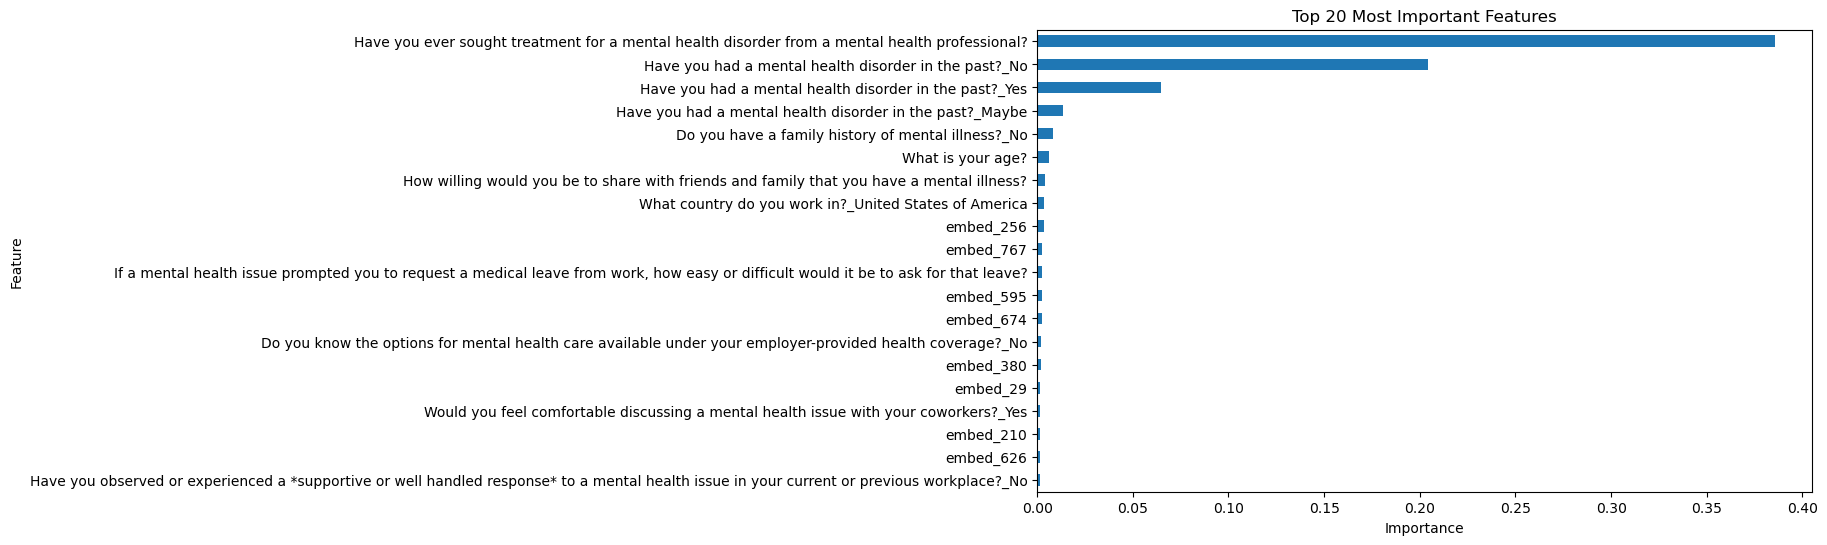

In [14]:
evaluate_model(
    model=best_rf,
    X_test=X_test,
    y_test=y_test,
)

# Gradient Boosting

Gradient Boosting is a machine learning method that builds a model step by step. 
Instead of training all decision trees independently (like Random Forest does), 
Gradient Boosting trains each tree to fix the mistakes made by the previous one. 
This sequential learning often results in strong performance, especially on 
structured tabular data.

The method can be quite powerful, but also sensitive to hyperparameters such as 
learning rate, number of trees, and tree depth. With careful tuning Gradient Boosting can provide a solid 
balance between accuracy and generalization.


In [15]:
lgbm = LGBMClassifier(
    objective="binary",
    random_state=1,
    n_jobs=-1
)

param_dist = {
    "num_leaves": [31, 63, 127, 255],
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800, 1200, 2000],
    "min_child_samples": [5, 10, 20, 40, 60],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "reg_lambda": [0.0, 0.1, 0.5, 1.0],
}

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=3,           
    scoring="accuracy",
    cv=5,                
    verbose=1,
    random_state=5,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_lgbm = search.best_estimator_

print("Best parameters:", search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 1107, number of negative: 894
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195961
[LightGBM] [Info] Number of data points in the train set: 2001, number of used features: 837
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553223 -> initscore=0.213703
[LightGBM] [Info] Start training from score 0.213703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

C:\Users\jakshend\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jakshend\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Confusion Matrix:
[[248  13]
 [ 56 184]]

  tp, fn
  fp, tn

Accuracy:   0.862
Precision:  0.816
Recall:     0.950
F1 Score:   0.878
ROC-AUC:    0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       240
           1       0.82      0.95      0.88       261

    accuracy                           0.86       501
   macro avg       0.87      0.86      0.86       501
weighted avg       0.87      0.86      0.86       501



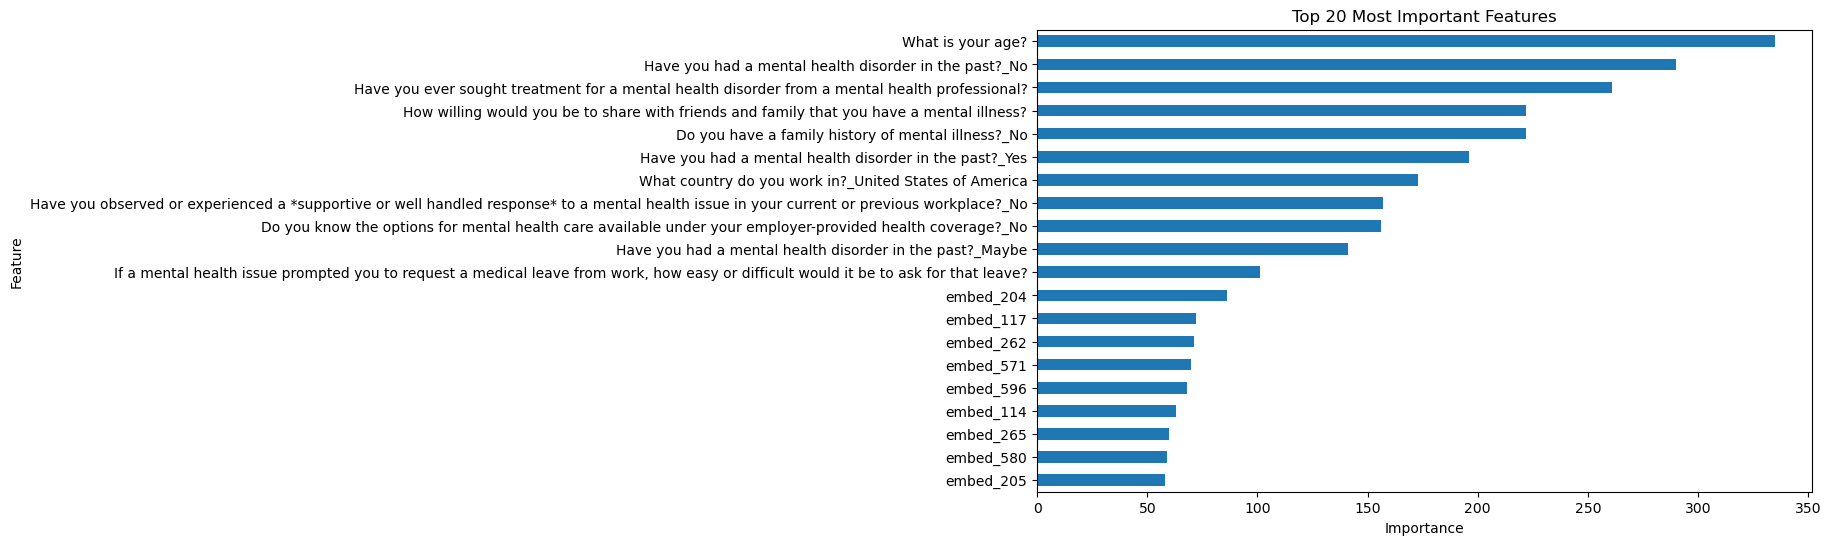

In [16]:
evaluate_model(
    model=best_lgbm,
    X_test=X_test,
    y_test=y_test
)

## Kernel SVM

A kernel SVM extends the basic linear support vector machine by allowing the 
decision boundary to become nonlinear. This is achieved through the kernel trick, 
where the data is implicitly mapped into a higher-dimensional feature space. 
The most commonly used kernel is the RBF (Radial Basis Function), which enables 
the model to form smooth, flexible boundaries that can capture more complex 
patterns in the data.

Kernel SVMs are sensitive to feature scaling, so we apply `StandardScaler` before 
training. Two important hyperparameters control the behavior of the model: `C`, 
which determines how strictly misclassifications are penalized, and `gamma`, 
which defines how far the influence of a single training point reaches. Tuning 
these parameters using cross-validation can help the model generalize more 
effectively.


In [17]:
param_dist = {
    "clf__C": np.logspace(-3, 3, 20),
    "clf__gamma": np.logspace(-4, 2, 20),
    "clf__kernel": ["rbf"]
}

svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=1))
])

search = RandomizedSearchCV(
    svc_pipeline,
    param_distributions=param_dist,
    n_iter=3,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=1
)

search.fit(X_train, y_train)

best_svc = search.best_estimator_
print("Best parameters:", search.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'clf__kernel': 'rbf', 'clf__gamma': np.float64(5.455594781168514), 'clf__C': np.float64(2.976351441631316)}


In [18]:
evaluate_model(
    model=best_svc,
    X_test=X_test,
    y_test=y_test
)

Confusion Matrix:
[[261   0]
 [240   0]]

  tp, fn
  fp, tn

Accuracy:   0.521
Precision:  0.521
Recall:     1.000
F1 Score:   0.685
ROC-AUC:    0.500

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.52      1.00      0.69       261

    accuracy                           0.52       501
   macro avg       0.26      0.50      0.34       501
weighted avg       0.27      0.52      0.36       501


No feature importances available for this model.


## Why Kernel SVM Failed

The kernel SVM model collapsed into predicting a single class because the feature
space is not suitable for margin-based separation. The combination of high-dimensional PCA embeddings and structured features introduces too much noise and
distortion for the kernel to form a meaningful nonlinear boundary. Even with
scaling and balanced class weights, the model cannot find a separating surface
and therefore defaults to predicting the same class for all samples. This behavior
is typical when SVM is applied to noisy, mixed-type, or highly overlapping data.


# ROC Curve Comparison (Random Forest, LightGBM, Kernel SVM)

To visually compare the performance of our tuned models, we plot all three ROC
curves on the same graph.

The ROC curve shows how each model balances true positive rate and false positive
rate across different classification thresholds. The area under the curve (AUC)
summarizes the overall performance: a higher AUC means better discrimination
between the positive and negative classes.


C:\Users\jakshend\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


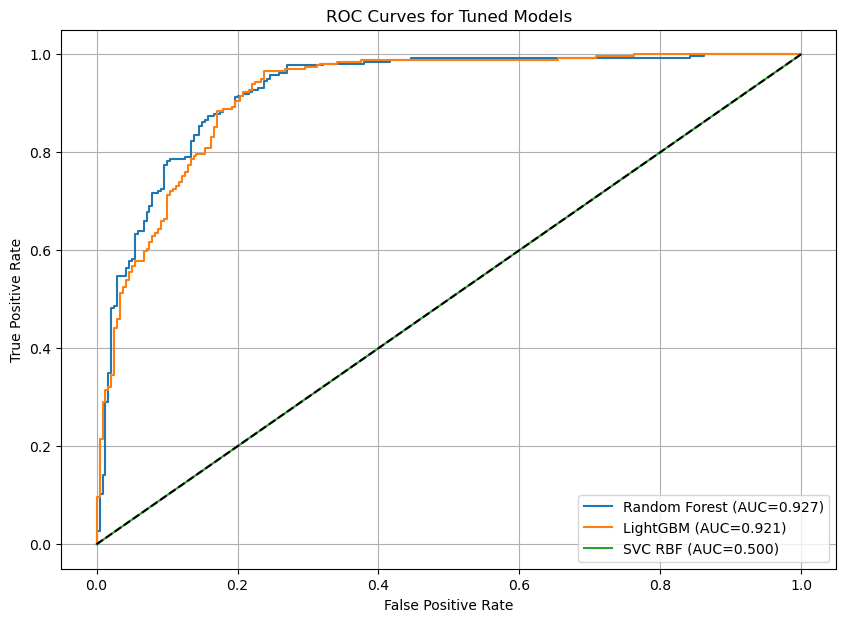

In [19]:
def plot_three_roc(rf, lgbm, svc, X_test, y_test):
    plt.figure(figsize=(10, 7))

    y_prob_rf = rf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    auc_rf = roc_auc_score(y_test, y_prob_rf)
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})")

    y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
    auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
    plt.plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC={auc_lgbm:.3f})")

    y_prob_svc = svc.predict_proba(X_test)[:, 1]
    fpr_svc, tpr_svc, _ = roc_curve(y_test, y_prob_svc)
    auc_svc = roc_auc_score(y_test, y_prob_svc)
    plt.plot(fpr_svc, tpr_svc, label=f"SVC RBF (AUC={auc_svc:.3f})")

    # Chance line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Tuned Models")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_three_roc(best_rf, best_lgbm, best_svc, X_test, y_test)


# Does embedding make the model better?

To answer this question, we evaluate three different versions of the feature set:

1. **Without embeddings**  
   Only the categorical and numerical features are used. This serves as the 
   baseline accuracy and shows how well the model performs using structured data 
   alone.

2. **With raw embeddings**  
   The full 768-dimensional embeddings are added directly, without PCA. This tests 
   whether the text features help the model in their original form or whether the 
   high dimensionality makes them too noisy.

3. **With PCA-reduced embeddings**  
   The 768-dimensional embeddings are reduced to 256 components using PCA. 
   This helps remove noise and may make it easier for the model to use the text 
   information effectively.

Each of these configurations is evaluated using the same 10-fold stratified 
cross-validation setup to ensure a fair and reliable comparison. By checking the 
average accuracy across folds, we can clearly see whether embeddings improve the 
model, whether PCA helps, and whether the structured features alone are already 
strong enough.


In [20]:
def evaluate(X, y):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = RandomForestClassifier(random_state=1)
    return cross_val_score(model, X, y, cv=cv, scoring="accuracy")

#baseline
X_no_emb = np.hstack([X_cat, X_num])
scores_no_emb = evaluate(X_no_emb, y)


# Raw embeddings
X_emb_raw = np.hstack([X_cat, X_num, embeddings])
scores_emb_raw = evaluate(X_emb_raw, y)


# PCA-reduced embeddinga
pca = PCA(n_components=256)
X_emb_pca = pca.fit_transform(embeddings)
X_with_pca = np.hstack([X_cat, X_num, X_emb_pca])

scores_with_pca = evaluate(X_with_pca, y)

print("Without embeddings:", scores_no_emb.mean())
print("With raw embeddings:", scores_emb_raw.mean())
print("With PCA embeddings:", scores_with_pca.mean())


Without embeddings: 0.8701163346613546
With raw embeddings: 0.8481290836653386
With PCA embeddings: 0.8621211155378485


## Impact of Embeddings on Model Performance

The results show that adding text embeddings does not improve model accuracy and in fact reduces it, both in their raw form and after PCA dimensionality reduction. The structured categorical and numerical features alone provide the highest accuracy, suggesting that the embeddings introduce noise rather than useful signal. This indicates that the textual information in the dataset is either not informative for the prediction task or not represented in a way that benefits tree-based models.


<br>

### **TODO:** Our best model was Random Forest, see what is its best AUC score without embeddings - train it again!

### **TODO:** train a deep learning model & create more graphs